# Lattice design with Xsuite

We will uses as example the PIMM lattice developed by the TERA collaboration for proton and ion therapy ([CERN/PS 99-010](https://cds.cern.ch/record/385378/)) and implemented in the CNAO and MEDAUSTRON synchrotrons.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xtrack as xt

%config InlineBackend.figure_format = "retina"

### Build Environment and Define a Reference Particle

In [2]:
env = xt.Environment()
env.particle_ref = xt.Particles(kinetic_energy0=200e6)  # 200MeV
env.vars.default_to_zero = True  # Undefined variables in env are set to zero.

### Define Elements

In [3]:
# Element geometry
n_bends = 16
env["ang_mb"] = 2 * np.pi / n_bends
env["l_mb"] = 1.65
env["l_mq"] = 0.35

env.new("mb", parent=xt.RBend, length="l_mb", angle="ang_mb", k0_from_h=True)
env.new("mq", parent=xt.Quadrupole, length="l_mq");

In [4]:
# Quadrupole families with different strengths
env.new("qfa", parent="mq", k1="kqfa")
env.new("qfb", parent="mq", k1="kqfb")
env.new("qd", parent="mq", k1="kqd");

### Build Lattice Cells

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


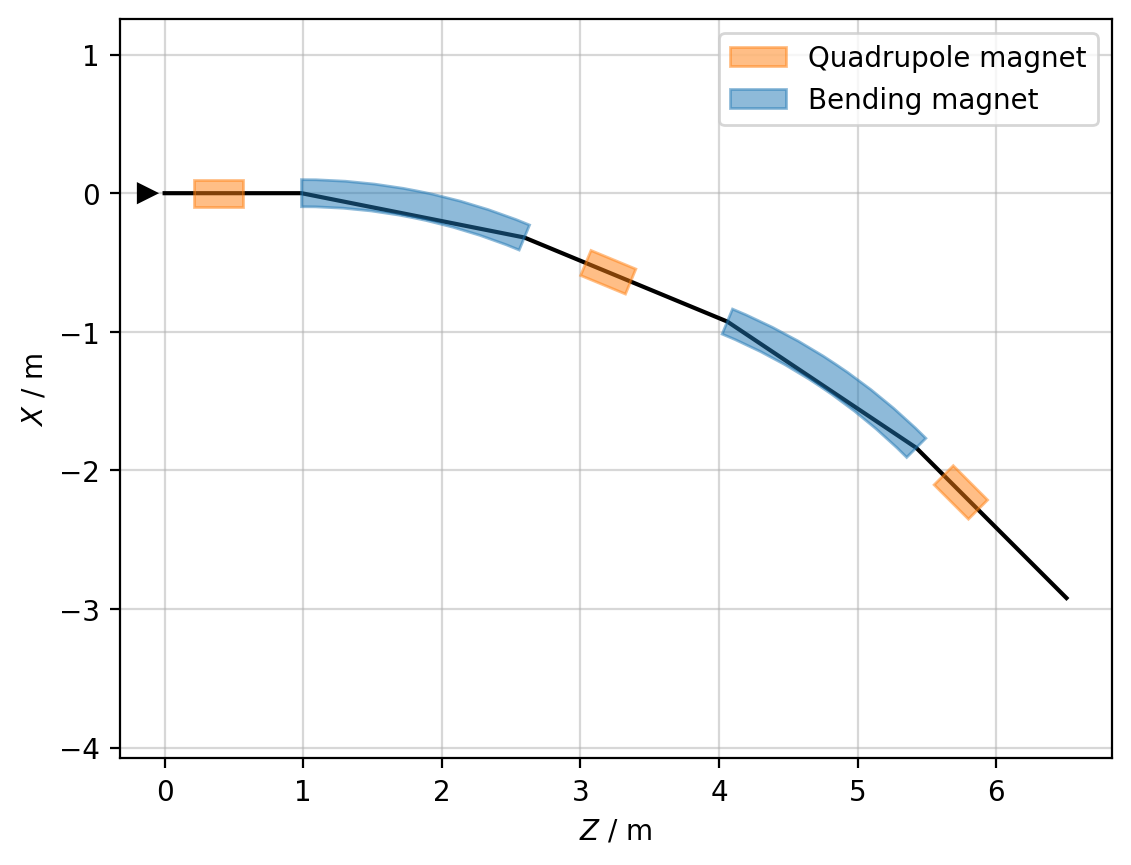

In [5]:
cell_a = env.new_line(
    length=7.405,
    components=[
        env.place("qfa", at=0.3875),
        env.place("mb", at=1.8125),
        env.place("qd", at=3.2925),
        env.place("mb", at=5.0475),
        env.place("qfa", at=6.3275),
    ],
)
cell_a.survey().plot()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


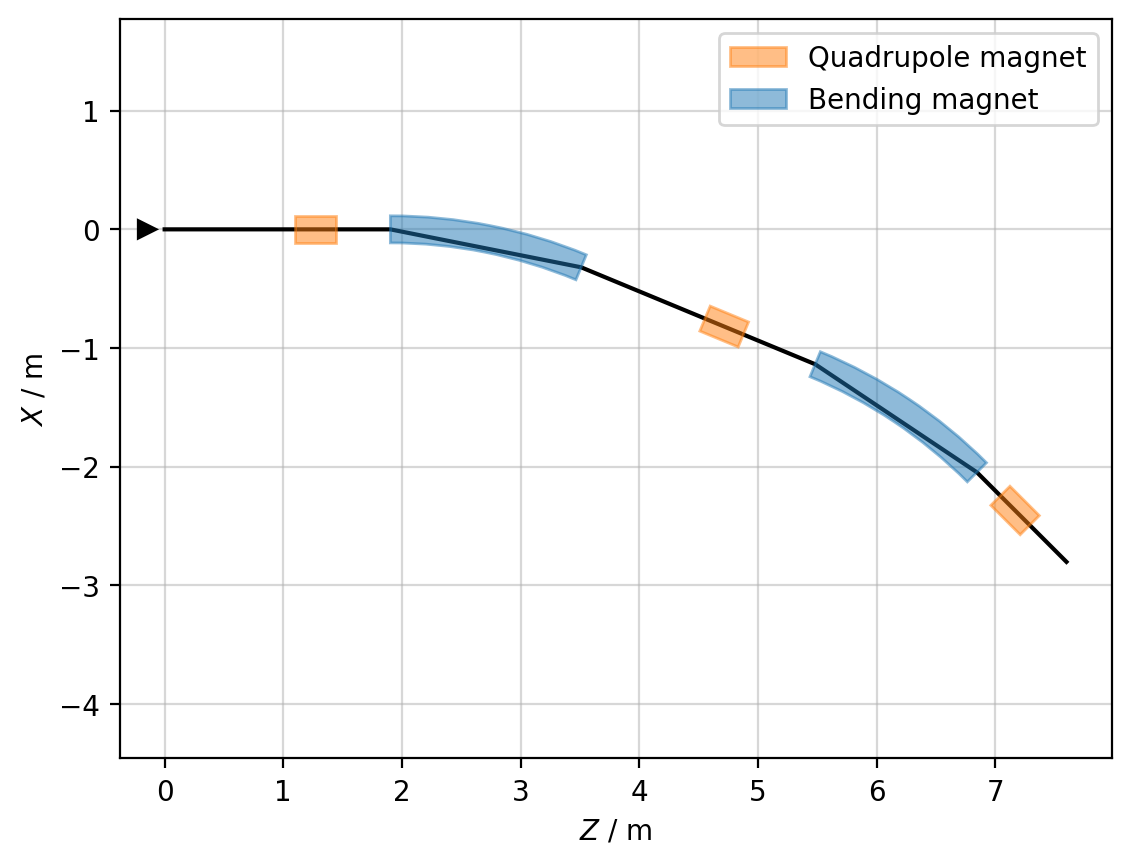

In [6]:
# Similar cell with second familiar of focusing quads
cell_b = env.new_line(
    name="cell_b",
    length=8.405,
    components=[
        env.place("qfb", at=1.2725),
        env.place("mb", at=2.7275),
        env.place("qd", at=4.8575),
        env.place("mb", at=6.5125),
        env.place("qfb", at=7.7925),
    ],
)
cell_b.survey().plot()

### Build an Arc

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


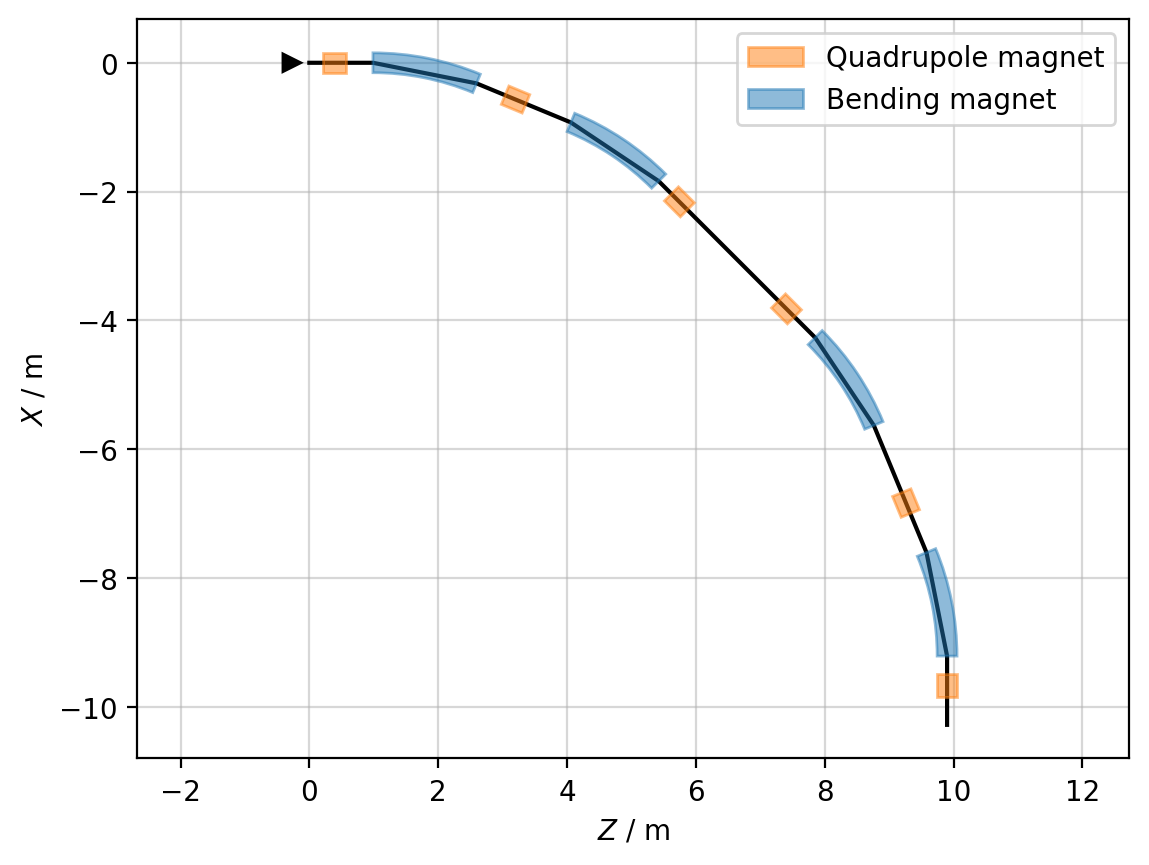

In [7]:
# Concatenate the two cells
arc = cell_a + cell_b
arc.survey().plot()

### Build Straight Sections

In [8]:
long_straight = env.new_line(length=2.0, components=[env.new("mid.lss", parent=xt.Marker, at=1.0)])
short_straight = env.new_line(length=1.0, components=[env.new("mid.sss", parent=xt.Marker, at=0.5)])

### Assemble the Ring

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


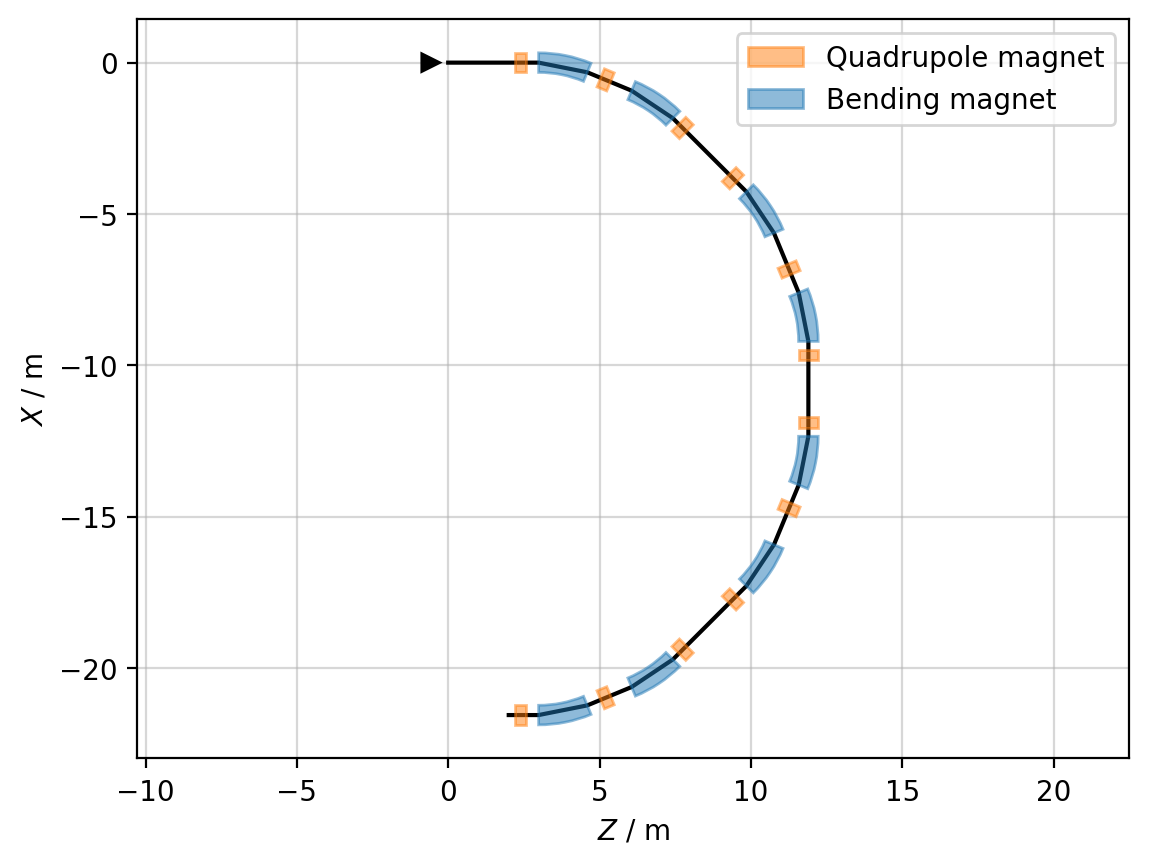

In [9]:
half_ring = long_straight + arc + short_straight - arc  # mirror symmetric lattice
half_ring.survey().plot()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


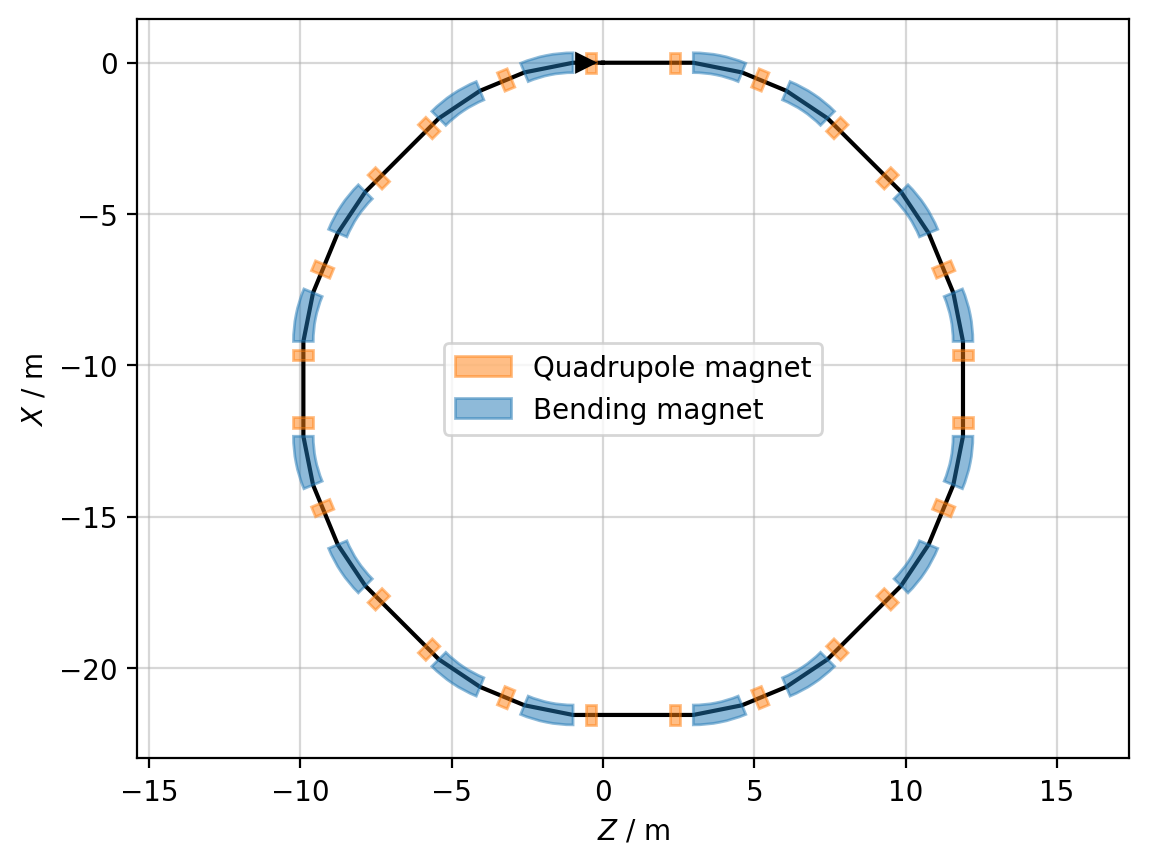

In [10]:
ring = 2 * half_ring
ring.survey().plot()

### Replace Repeated Elements

In [11]:
# Gives all elements unique names
ring.replace_all_repeated_elements()

### Inspect Beamline Table

In [12]:
table = ring.get_table()
table.cols["element_type", "s_start", "s_center", "s_end"]

Table: 101 rows, 5 cols
name       element_type       s_start      s_center         s_end
drift_13.0 Drift                    0           0.5             1
mid.lss.0  Marker                   1             1             1
drift_14.0 Drift                    1           1.5             2
drift_1.0  Drift                    2       2.10625        2.2125
qfa.0      Quadrupole          2.2125        2.3875        2.5625
drift_2.0  Drift               2.5625         2.775        2.9875
mb.0       RBend               2.9875        3.8125        4.6375
drift_3.0  Drift               4.6375        4.8775        5.1175
qd.0       Quadrupole          5.1175        5.2925        5.4675
drift_4.0  Drift               5.4675         5.845        6.2225
...
drift_5.3  Drift              63.0875       63.2275       63.3675
mb.14      RBend              63.3675       64.1925       65.0175
drift_4.3  Drift              65.0175        65.395       65.7725
qd.7       Quadrupole         65.7725       65.9

In [13]:
# Inspect all quadrupoles
table_quads = table.rows[table.element_type == "Quadrupole"]
table_quads.cols["s_start", "s_center", "s_end"]

Table: 24 rows, 4 cols
name        s_start      s_center         s_end
qfa.0        2.2125        2.3875        2.5625
qd.0         5.1175        5.2925        5.4675
qfa.1        8.1525        8.3275        8.5025
qfb.0       10.5025       10.6775       10.8525
qd.1        14.0875       14.2625       14.4375
qfb.1       17.0225       17.1975       17.3725
qfb.2       19.2475       19.4225       19.5975
qd.2        22.1825       22.3575       22.5325
qfb.3       25.7675       25.9425       26.1175
qfa.2       28.1175       28.2925       28.4675
qd.3        31.1525       31.3275       31.5025
qfa.3       34.0575       34.2325       34.4075
qfa.4       36.8325       37.0075       37.1825
qd.4        39.7375       39.9125       40.0875
qfa.5       42.7725       42.9475       43.1225
qfb.4       45.1225       45.2975       45.4725
qd.5        48.7075       48.8825       49.0575
qfb.5       51.6425       51.8175       51.9925
qfb.6       53.8675       54.0425       54.2175
qd.6        56.80

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


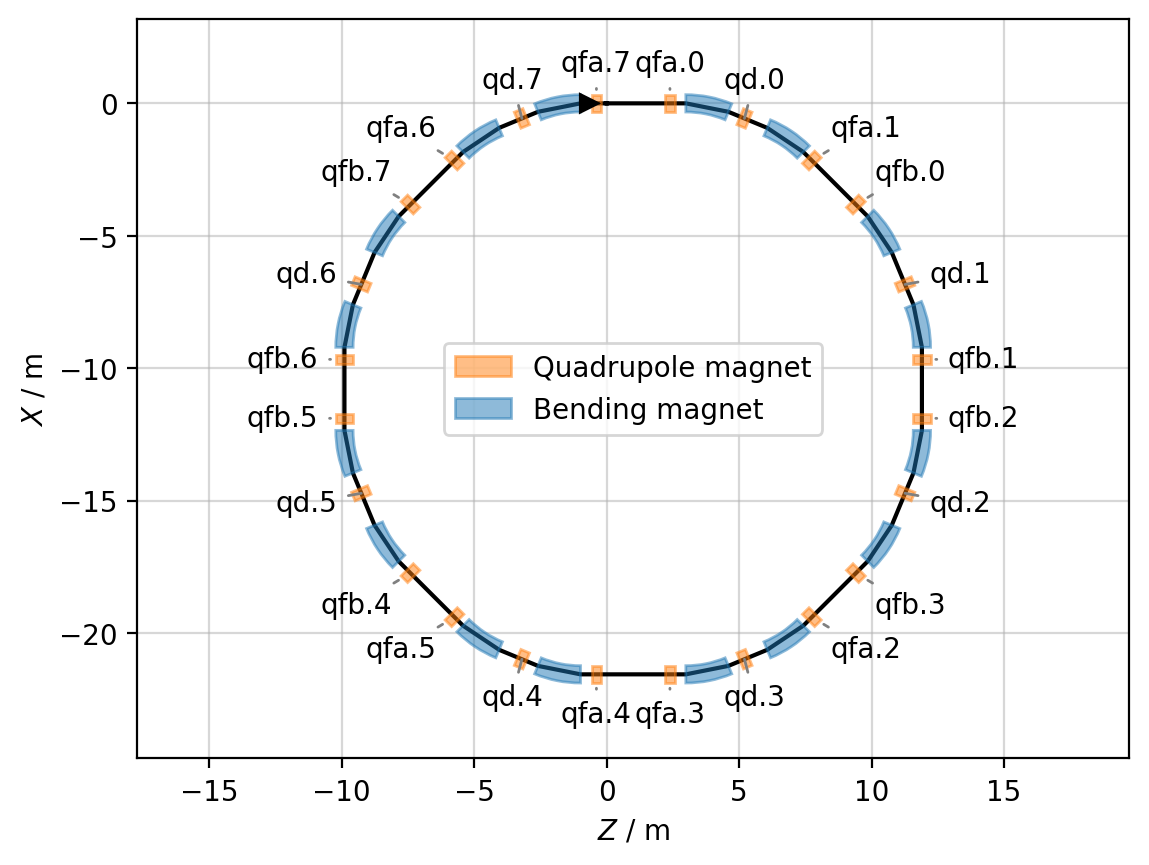

In [14]:
# Tag all quadrupoles in survey plot
sv = ring.survey()
sv.plot(labels=table_quads.name);

### Define and Install Sextupoles

In [15]:
# Magnet type
env.new("ms", parent=xt.Sextupole, length=0.2)

# Magnet instances
env.new("msf.1", parent="ms", k2="ksf")  # focusing
env.new("msf.2", parent="ms", k2="ksf")  # focusing
env.new("msd.1", parent="ms", k2="ksd")  # defocusing
env.new("msd.2", parent="ms", k2="ksd")  # defocusing
env.new("mse", parent="ms", k2="kse")  # for extraction

'mse'

In [16]:
ring.insert(
    [
        env.place("msf.1", at=-0.2, from_="qfb.0@start"),
        env.place("msf.2", at=-0.2, from_="qfb.4@start"),
        env.place("msd.1", at=0.3, from_="qd.2@end"),
        env.place("msd.2", at=0.3, from_="qd.6@end"),
        env.place("mse", at=-0.3, from_="qfa.4@start"),
    ]
)

Slicing line:   0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
%matplotlib widget

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


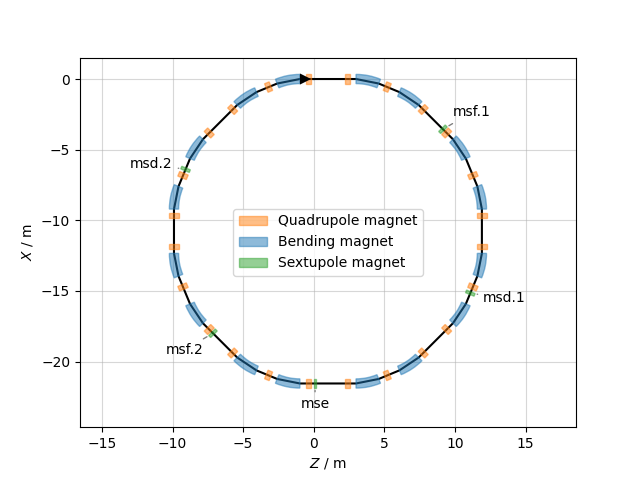

In [18]:
# Inspect sextupoles in the survey
survey = ring.survey()
survey.plot(labels=["msf.1", "msf.2", "msd.1", "msd.2", "mse"])

## Inspect Circuit Structure

In [19]:
# Entities controlled by one knob
env.info("ksf")

#  vars['ksf']._get_value()
   vars['ksf'] = 0.0

#  vars['ksf']._expr is None

#  vars['ksf']._find_dependant_targets()
   element_refs['msf.2'].k2
   element_refs['msf.1'].k2



In [20]:
# Inspect knob controlling one magnet
env.info("msf.1")

Element of type:  Sextupole
name                value                                                       expr       
k2                  0.0                                                         vars['ksf']
k2s                 0.0                                                         None       
length              0.2                                                         None       
order               5                                                           None       
inv_factorial_order 0.008333333333333333                                        None       
knl                 [0. 0. 0. 0. 0. 0.]                                         None       
ksl                 [0. 0. 0. 0. 0. 0.]                                         None       
edge_entry_active   0                                                           None       
edge_exit_active    0                                                           None       
num_multipole_kicks 0                               

### Install RF Cavity

In [21]:
env.new("rf1", parent=xt.Cavity, voltage="vrf", frequency="frf")
ring.insert("rf1", at=0.5, from_="qfa.3@start")

Slicing line:   0%|          | 0/109 [00:00<?, ?it/s]

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


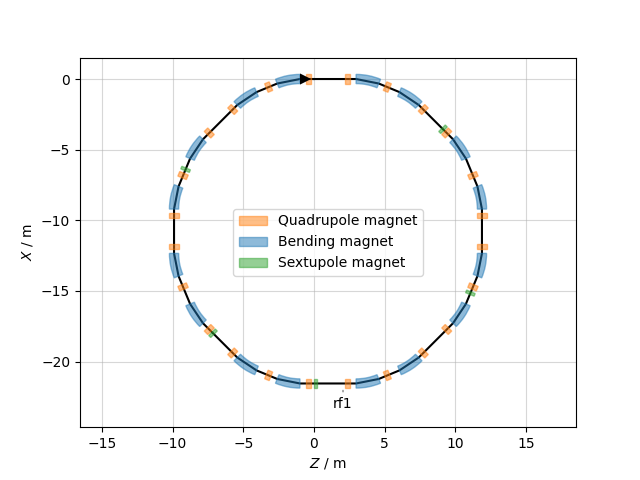

In [22]:
survey = ring.survey()
survey.plot(labels=["rf1"])

### Save lattice to json file

In [23]:
env["ring"] = ring
env.to_json("pimm.json")

---